## Figure 1
This notebook creates the panels showing quantitative data of Figure 1 of the paper (title and link here).


We start by finding and loading the data.

In [1]:
import numpy
import json

from matplotlib import pyplot as plt
from toposample import Config
from figure_helper import Figure


"""
Paths to relevant data. 
'spikes_in_fn' is a file that contains the input spikes given in the first 30s of the simulation
'clusters_fn' is a file that contains the specification of groups of input fibers that always fire together
Other relevant data is loaded from the main data set.
"""
spikes_in_fn = "additional_data/input.dat"
clusters_fn = "additional_data/clusters_100_v3.10.json"
cfg = Config("../working_dir/config/common_config.json")
output_spikes_fn = cfg._cfg['inputs']['raw_spikes']
stim_fn = cfg._cfg['inputs']['stimuli']
tribes_fn = cfg._cfg['analyzed']['tribes']


"""
Loading the data
"""
with open(spikes_in_fn, 'r') as fid:
    fid.readline()
    input_spikes = [list(map(float, ln.split())) for ln in fid]
input_spikes = numpy.array(input_spikes)
output_spikes = numpy.load(output_spikes_fn)
stims = numpy.load(stim_fn)
with open(clusters_fn, 'r') as fid:
    clusters = json.load(fid)
with open(tribes_fn, 'r') as fid:
    tribes = json.load(fid)

"""
Additional parameterization
"""
t_stims_start = cfg.stage("split_spikes")["config"]["t_stim_start"]
t_stim_dur = cfg.stage("split_spikes")["config"]["stim_duration_ms"]
t_win = [8000, 9200]
t_bins = numpy.arange(t_win[0], t_win[1] + 10, 10)
exemplary_tribe = ["Radius", "175 um", "0"]


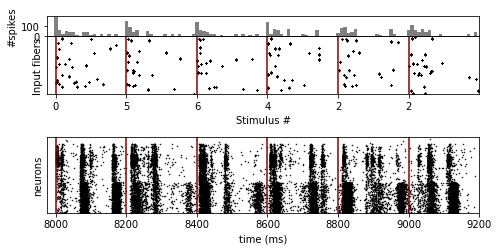

In [2]:
"""
Reorder input fibers such that clusters that fire together are visually grouped together
"""
clst_gids = [_grp['gids'] for _grp in clusters['groups'].values()]
plot_order = numpy.hstack(clst_gids).tolist()
s_out = output_spikes[(output_spikes[:, 0] > t_win[0]) & (output_spikes[:, 0] < t_win[1])]
s_in = input_spikes[(input_spikes[:, 0] > t_win[0]) & (input_spikes[:, 0] < t_win[1])]
s_in[:, 1] = [plot_order.index(_x) for _x in s_in[:, 1]]

"""
Histogram of number of input spikes
"""
input_hist = numpy.histogram(s_in[:, 0], bins=t_bins)[0]


F = Figure("figures/Figure1")
"""PLOT:
Central panel: Raster plot of input spikes
"""
fig = plt.figure(figsize=(7.5, 3.5))
ax = fig.add_axes([0.1, 0.62, 0.8, 0.23])
ax.plot(s_in[:, 0], s_in[:, 1], '.k', ms=1)
ax.set_ylim([0, 2170])
xticks = []
xticklabels = []
for y in numpy.arange(t_win[0], t_win[1], 200):
    ax.plot([y, y], ax.get_ylim(), color='maroon')
    xticks.append(y)
    xticklabels.append(stims[int((y - t_stims_start) / t_stim_dur)])
ax.set_xticks(xticks); ax.set_xticklabels(xticklabels)
ax.set_xlabel("Stimulus #")
ax.set_yticks([])
ax.set_ylabel('Input fibers')
ax.set_xlim([t_win[0] - 25, t_win[1]])
    
"""
Top panel: Histogram of number of input spikes
"""
ax = fig.add_axes([0.1, 0.85, 0.8, 0.08])
ax.bar(t_bins[:-1], input_hist, color='grey', width=10)
ax.set_xticks([])
ax.set_ylabel("#spikes")
ax.set_xlim([t_win[0] - 25, t_win[1]])

"""
Bottom panel: Raster plot of output (simulated) spikes
"""
ax = fig.add_axes([0.1, 0.15, 0.8, 0.3])
ax.plot(s_out[:, 0], s_out[:, 1], '.k', ms=1)
ax.set_ylim([93000, 64000])
for y in numpy.arange(t_win[0], t_win[1], 200):
    ax.plot([y, y], ax.get_ylim(), color='maroon')
ax.set_xlabel("time (ms)")
ax.set_yticks([])
ax.set_ylabel("neurons")
ax.set_xlim([t_win[0] - 25, t_win[1]])

F.save(fig, fn="panel_a")

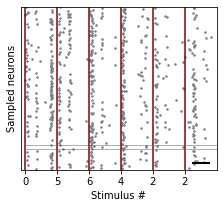

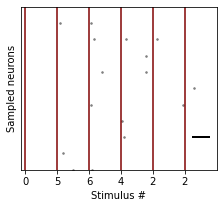

In [11]:
gids_selected = tribes[exemplary_tribe[0]][exemplary_tribe[1]][exemplary_tribe[2]]["gids"]
gids_selected = [_g for _g in gids_selected if _g in s_out[:, 1]]

fig = plt.figure(figsize=(3.5, 3.0))
ax = fig.gca()
s_out_s = s_out[numpy.in1d(s_out[:, 1], gids_selected), :]
s_out_s[:, 1] = [gids_selected.index(_x) for _x in s_out_s[:, 1]]
ax.plot(s_out_s[:, 0], s_out_s[:, 1], '.', ms=3, color='grey')

ax.set_ylim([0, len(gids_selected)])
xticks = []
xticklabels = []
for y in numpy.arange(t_win[0], t_win[1], 200):
    ax.plot([y, y], ax.get_ylim(), color='maroon')
    xticks.append(y)
    xticklabels.append(stims[int((y - t_stims_start) / t_stim_dur)])
#for x in numpy.arange(0.5, len(gids_selected) + 0.5, 1):
#    ax.plot(t_win, [x, x], lw=0.1, ls='--', color='grey')
ax.set_xticks(xticks); ax.set_xticklabels(xticklabels)
ax.set_xlabel("Stimulus #")
ax.set_yticks([])
ax.set_ylabel('Sampled neurons')
ax.set_xlim([t_win[0] - 25, t_win[1]])

ax.plot([t_win[1] - 150, t_win[1] - 50], [15, 15], lw=2, color='black')

F.save(fig, fn="panel_b")

ax.plot(t_win, [45, 45], lw=0.5, color=[0.35, 0.35, 0.55])
ax.plot(t_win, [55, 55], lw=0.5, color=[0.35, 0.35, 0.55])

fig = plt.figure(figsize=(3.5, 3.0))
ax = fig.gca()
in_inset = (s_out_s[:, 1] >= 45) & (s_out_s[:, 1] < 55)
ax.plot(s_out_s[in_inset, 0], s_out_s[in_inset, 1], '.', ms=3, color='grey')

ax.set_ylim([45, 55])
xticks = []
xticklabels = []
for y in numpy.arange(t_win[0], t_win[1], 200):
    ax.plot([y, y], ax.get_ylim(), color='maroon')
    xticks.append(y)
    xticklabels.append(stims[int((y - t_stims_start) / t_stim_dur)])

ax.set_xticks(xticks); ax.set_xticklabels(xticklabels)
ax.set_xlabel("Stimulus #")
ax.set_yticks([])
ax.set_ylabel('Sampled neurons')
ax.set_xlim([t_win[0] - 25, t_win[1]])

ax.plot([t_win[1] - 150, t_win[1] - 50], [47, 47], lw=2, color='black')
